## Models Output

### First method:
  - **Output**
    - Accuracy: 0.6706
    - Macro F1 Score: 0.6584
    - AUROC: 0.9324
  - ResNet:
    - **Input Layer Modification**: Adjusted to take grayscale images.
    - **Forward Pass**: Resizes input and feeds through ResNet-18.
  -LitResNet:
    - **Fully Connected Layer**: Custom block with linear, batch norm, ReLU, dropout, and classification.
    - **Loss Function**: Focal Loss for handling class imbalance.
    - **Optimization**: AdamW optimizer with learning rate 0.001 and weight decay 1e-4.
    - **Learning Rate Scheduler**: Lowers learning rate when validation accuracy plateaus.
    - **Loggin**g: Logs validation loss and accuracy every epoch.
    - **Training and Validation**: Computes loss and accuracy, logs metrics.
    - **Test Step**: Evaluates loss, accuracy, F1 score, AUROC, and confusion matrix.

### Second method:
  - **Output**
    - Accuracy: 0.6954
    - Macro F1 Score: 0.6899
    - AUROC: 0.9446
  - LitResNet2:
    - **Optimizer**: AdamW optimizer is used to improve generalization by decoupling weight decay from the gradient update.
    - **Learning Rate Scheduler**: ReduceLROnPlateau decreases the learning rate by a factor of 0.5 when validation accuracy plateaus.

### Third method:
  - **Output**
    - Accuracy: 0.7468
    - Macro F1 Score: 0.7398
    - AUROC: 0.9558
  - LitResNet3:
    - **Focal Loss**: Replaces CrossEntropyLoss to address class imbalance by focusing more on difficult-to-classify samples.
    - **Fully Connected Layer Enhancements**: Adds Batch Normalization, ReLU activation, and Dropout to the fully connected layer to improve generalization and reduce overfitting.

### Fourth method:
  - **Output**
    - Accuracy: 0.7798
    - Macro F1 Score: 0.7718
    - AUROC: 0.9642
  - LitResNet4:
    - **Dice Loss**: Replaces FocalLoss to address imbalanced multi-class classification.
    - **ResNet 152**: Grayscale input weights were adjusted.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment'

%cd "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment"

import os
assert os.path.exists(DATASET_PATH), "[!] Dataset path does not exist. Please check the path."

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment


In [ ]:
%%capture
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
  %pip install lightning polars
  %pip install icecream rich tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pytorch_lightning as L
from torchvision.models import resnet18
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint
from pathlib import Path
import polars as pl
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms as v2

In [ ]:
print("GPU available:", torch.cuda.is_available())

GPU available: False


In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pl.DataFrame, training=False):
        super().__init__()
        paths = dataframe['image_path'].to_numpy().squeeze()
        self.image_path = np.array([
            str(Path('preprocessed_garbage_classification_images') / Path(p).name)
            for p in paths
        ])
        self.garbage_type = dataframe.select('label').to_numpy().squeeze()
        self.garbage_to_idx = {garbage: i for i, garbage in enumerate(np.unique(self.garbage_type))}
        self.training = training

        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.RandomVerticalFlip(),
            v2.RandomErasing(),
        ])

        self.transforms = v2.Normalize(mean=[0.5], std=[0.5])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]

        try:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            image = torch.from_numpy(image).float()

            if image.dim() == 2:
                image = image.unsqueeze(0)

            if self.training:
                image = self.train_transforms(image)

            image = self.transforms(image)

            garbage = self.garbage_to_idx[self.garbage_type[idx]]

            return image, torch.tensor(garbage, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

class GarbageClassificationData(L.LightningDataModule):
    def __init__(self, ws_root: Path = Path("."), num_workers=0):
        super().__init__()
        metadata_path = ws_root / 'preprocessed_garbage_classification_images' / 'metadata'
        self.train_ds = ImageDataset(pl.read_csv(metadata_path / 'train.csv'), training=True)
        self.val_ds = ImageDataset(pl.read_csv(metadata_path / 'validation.csv'))
        self.test_ds = ImageDataset(pl.read_csv(metadata_path / 'test.csv'))

        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=32, shuffle=True, **self.dataloader_extras)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds, batch_size=64, **self.dataloader_extras)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_ds, batch_size=64, **self.dataloader_extras)

    def print_class_distribution(self):
        def count_classes(dataset):
            unique, counts = np.unique(dataset.garbage_type, return_counts=True)
            return dict(zip(unique, counts))

        train_counts = count_classes(self.train_ds)
        val_counts = count_classes(self.val_ds)
        test_counts = count_classes(self.test_ds)

        print("Training Dataset Class Distribution:")
        for label, count in train_counts.items():
            print(f"  {self.idx_to_garbage[label]}: {count}")

        print("\nValidation Dataset Class Distribution:")
        for label, count in val_counts.items():
            print(f"  {self.idx_to_garbage[label]}: {count}")

        print("\nTesting Dataset Class Distribution:")
        for label, count in test_counts.items():
            print(f"  {self.idx_to_garbage[label]}: {count}")


In [ ]:
class ResNetModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolution layer to accept grayscale input
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        with torch.no_grad():
            self.model.conv1.weight.data = original_conv.weight.data[:, :1, :, :]

        # Adjust the fully connected layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.model(x)

# Define your LitResNet class (updated with grayscale support)
class LitResNet(L.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolution layer to accept grayscale input
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        with torch.no_grad():
            self.model.conv1.weight.data = original_conv.weight.data[:, :1, :, :]

        # Adjust the fully connected layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=num_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

        # Store outputs for later analysis
        self.test_outputs = []

        # Save hyperparameters
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)

        # Compute metrics
        self.test_accuracy(outputs.argmax(dim=1), labels)
        self.test_f1(outputs.argmax(dim=1), labels)
        self.test_auroc(torch.nn.functional.softmax(outputs, dim=1), labels)
        self.test_confusion_matrix(outputs.argmax(dim=1), labels)

        # Store outputs for potential later analysis
        self.test_outputs.append({
            'y_pred': outputs,
            'y_true': labels
        })

        return {'test_loss': loss, 'test_acc': (outputs.argmax(dim=1) == labels).float().mean()}

    def on_test_epoch_end(self):
        accuracy = self.test_accuracy.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        self.log('test_accuracy', accuracy)
        self.log('test_f1_score', f1_score)
        self.log('test_auroc', auroc)

        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

In [ ]:
# Training script setup
checkpoint_dir = Path('checkpoints/resnet18')
checkpoint_callback = ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='resnet18-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    monitor='val_acc',
    mode='max'
)

logger = L.loggers.TensorBoardLogger(save_dir='logs', name='resnet18')
trainer = L.Trainer(max_epochs=10, accelerator='gpu', callbacks=[checkpoint_callback], logger=logger)

# Model training
garbage_classification_data = GarbageClassificationData(num_workers=4)
lit_model = LitResNet(garbage_classification_data.n_classes)
trainer.fit(model=lit_model, datamodule=garbage_classification_data)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/50.021 Artificial Intelligence Group Assignment/checkpoints/resnet18 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | ResNet                    | 11.2 M | train
1 | loss_fn               | CrossEntropyLoss          | 0      | train
2 | test_accuracy         | MulticlassAccuracy        | 0      | train
3 | test_f1               | Mult

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.6706
Macro F1 Score: 0.6584
AUROC: 0.9324


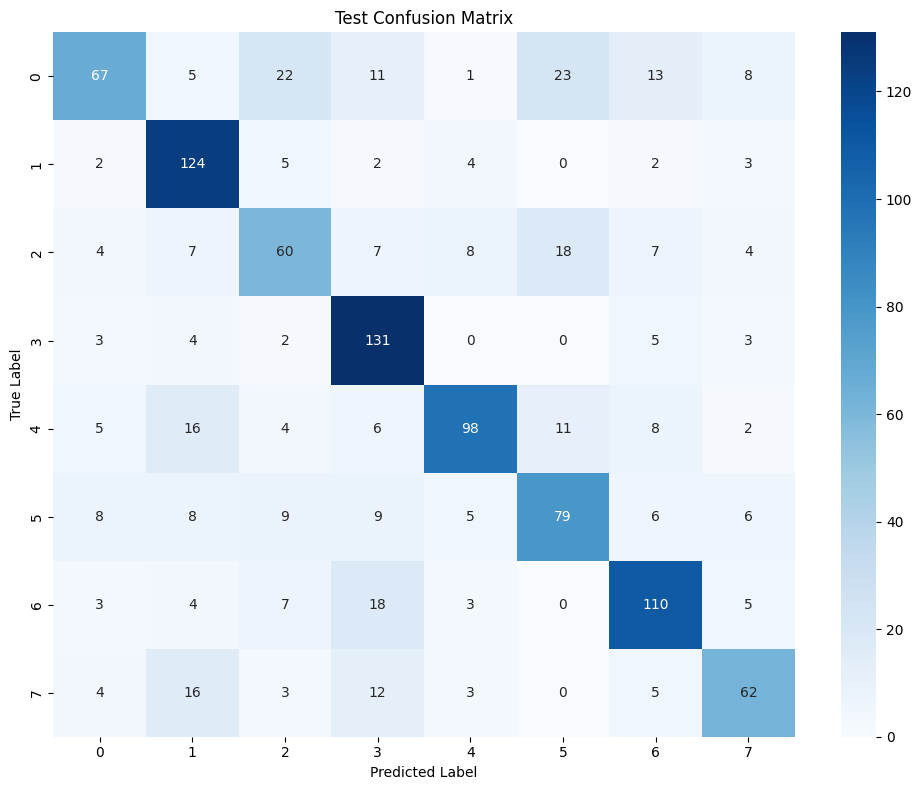

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6706421971321106     │
│        test_auroc         │    0.9323772192001343     │
│       test_f1_score       │    0.6583603620529175     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.6706421971321106,
  'test_f1_score': 0.6583603620529175,
  'test_auroc': 0.9323772192001343}]

In [ ]:
# Load the model checkpoint correctly using the class itself
checkpoint_path = Path('checkpoints/resnet18/resnet18-epoch=08-val_acc=0.69.ckpt')

# Load the model from the checkpoint (using the class, not an instance)
lit_model = LitResNet.load_from_checkpoint(checkpoint_path, num_classes=garbage_classification_data.n_classes)

# Testing setup (no training)
trainer = L.Trainer(accelerator='gpu')

# Run the test phase
trainer.test(model=lit_model, datamodule=garbage_classification_data)

In [ ]:
"""
- Replace the Optimizer with AdamW (improves generalization by decoupling weight decay from the gradient update)
- Use a Learning Rate Scheduler
"""


# Define your LitResNet class (updated with grayscale support)
class LitResNet2(L.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolution layer to accept grayscale input
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        with torch.no_grad():
            self.model.conv1.weight.data = original_conv.weight.data[:, :1, :, :]

        # Adjust the fully connected layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=num_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

        # Store outputs for later analysis
        self.test_outputs = []

        # Save hyperparameters
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)

        # Compute metrics
        self.test_accuracy(outputs.argmax(dim=1), labels)
        self.test_f1(outputs.argmax(dim=1), labels)
        self.test_auroc(torch.nn.functional.softmax(outputs, dim=1), labels)
        self.test_confusion_matrix(outputs.argmax(dim=1), labels)

        # Store outputs for potential later analysis
        self.test_outputs.append({
            'y_pred': outputs,
            'y_true': labels
        })

        return {'test_loss': loss, 'test_acc': (outputs.argmax(dim=1) == labels).float().mean()}

    def on_test_epoch_end(self):
        accuracy = self.test_accuracy.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        self.log('test_accuracy', accuracy)
        self.log('test_f1_score', f1_score)
        self.log('test_auroc', auroc)

        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def configure_optimizers(self):
      optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          optimizer, mode='max', factor=0.5, patience=3, verbose=True
      )
      return {
          'optimizer': optimizer,
          'lr_scheduler': {
              'scheduler': scheduler,
              'monitor': 'val_acc'  # Make sure to monitor 'val_acc'
          }
      }


      return [optimizer], [scheduler]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using device: cuda


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | ResNet                    | 11.2 M | train
1 | loss_fn               | CrossEntropyLoss          | 0      | train
2 | test_accuracy         | MulticlassAccuracy        | 0      | train
3 | test_f1               | MulticlassF1Score         | 0      | train
4 | test_auroc            | MulticlassAUROC           | 0      | train
5 | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.697    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.6954
Macro F1 Score: 0.6899
AUROC: 0.9446


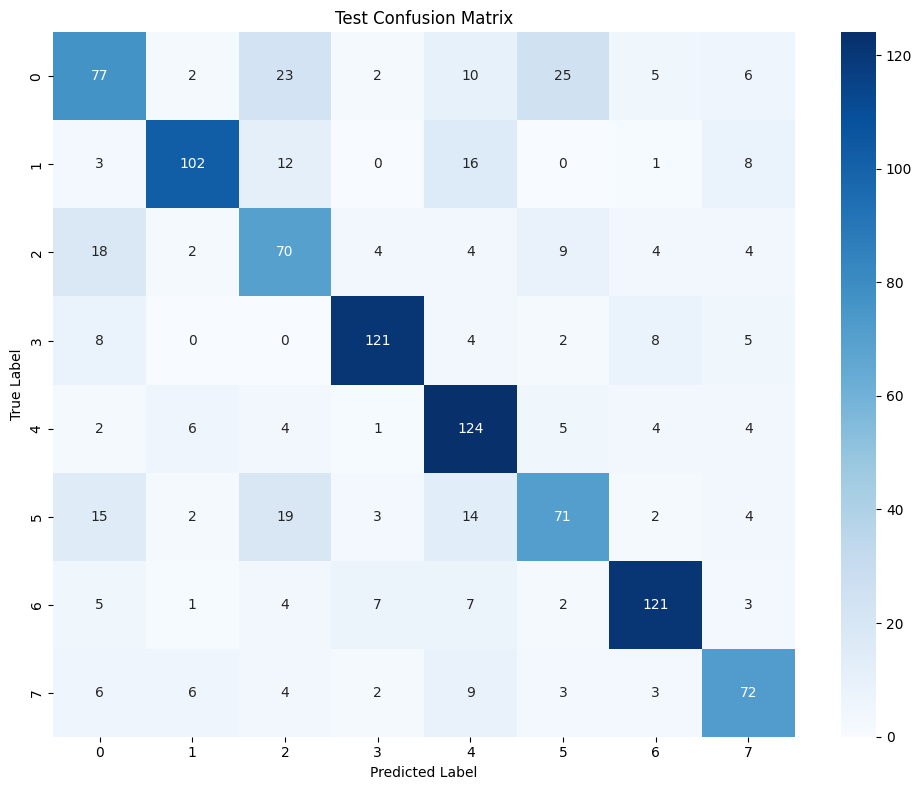

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.695412814617157     │
│        test_auroc         │    0.9445586204528809     │
│       test_f1_score       │    0.6898921728134155     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.695412814617157,
  'test_f1_score': 0.6898921728134155,
  'test_auroc': 0.9445586204528809}]

In [ ]:

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training script setup
checkpoint_dir = Path('checkpoints/resnet18')
checkpoint_callback = L.callbacks.ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='resnet18-v2-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    monitor='val_acc',
    mode='max'
)

logger = L.loggers.TensorBoardLogger(save_dir='logs', name='resnet18')

trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',  # Ensure GPU is being used
    devices=1,          # Use a single GPU
    callbacks=[checkpoint_callback],
    logger=logger,
    log_every_n_steps=10,  # Log more frequently
)

# Model training
garbage_classification_data = GarbageClassificationData(num_workers=4)
lit_model = LitResNet2(garbage_classification_data.n_classes)

# Train the model
trainer.fit(model=lit_model, datamodule=garbage_classification_data)

# Test the model after training
trainer.test(model=lit_model, datamodule=garbage_classification_data)

In [ ]:
# Replace CrossEntropyLoss with FocalLoss to handle class imbalance by focusing on hard-to-classify samples
# Add Batch Normalization, ReLU activation, and Dropout in the fully connected layer to enhance generalization

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss

class LitResNet3(L.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolution layer to accept grayscale input
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        with torch.no_grad():
            self.model.conv1.weight.data = original_conv.weight.data[:, :1, :, :]

        # Adjust the fully connected layer to match the number of classes
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self.loss_fn = FocalLoss()

        # Initialize metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=num_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        self.test_outputs = []

        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)

        self.test_accuracy(outputs.argmax(dim=1), labels)
        self.test_f1(outputs.argmax(dim=1), labels)
        self.test_auroc(torch.nn.functional.softmax(outputs, dim=1), labels)
        self.test_confusion_matrix(outputs.argmax(dim=1), labels)

        self.test_outputs.append({
            'y_pred': outputs,
            'y_true': labels
        })

        return {'test_loss': loss, 'test_acc': (outputs.argmax(dim=1) == labels).float().mean()}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_acc'
            }
        }

    def on_test_epoch_end(self):
        accuracy = self.test_accuracy.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        self.log('test_accuracy', accuracy)
        self.log('test_f1_score', f1_score)
        self.log('test_auroc', auroc)

        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()


In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training script setup
checkpoint_dir = Path('checkpoints/resnet18')
checkpoint_callback = L.callbacks.ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='resnet18-v3-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    monitor='val_acc',
    mode='max'
)

# Early stopping callback
early_stopping_callback = L.callbacks.EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=5,
    verbose=True
)

logger = L.loggers.TensorBoardLogger(save_dir='logs', name='resnet18')

trainer = L.Trainer(
    max_epochs=20,
    accelerator='gpu',  # Ensure GPU is being used
    devices=1,          # Use a single GPU
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=logger,
    log_every_n_steps=10,  # Log more frequently
)

# Model training
garbage_classification_data = GarbageClassificationData(num_workers=4)
lit_model = LitResNet3(garbage_classification_data.n_classes)

# Train the model
trainer.fit(model=lit_model, datamodule=garbage_classification_data)

# Test the model after training
trainer.test(model=lit_model, datamodule=garbage_classification_data)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using device: cuda


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | ResNet                    | 11.4 M | train
1 | loss_fn               | FocalLoss                 | 0      | train
2 | test_accuracy         | MulticlassAccuracy        | 0      | train
3 | test_f1               | MulticlassF1Score         | 0      | train
4 | test_auroc            | MulticlassAUROC           | 0      | train
5 | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.752    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.440


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.112 >= min_delta = 0.0. New best score: 0.552


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.054 >= min_delta = 0.0. New best score: 0.606


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.023 >= min_delta = 0.0. New best score: 0.629


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.634


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.039 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.069 >= min_delta = 0.0. New best score: 0.742


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.749


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.751
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]


--- Test Metrics ---
Accuracy: 0.7468
Macro F1 Score: 0.7398
AUROC: 0.9558


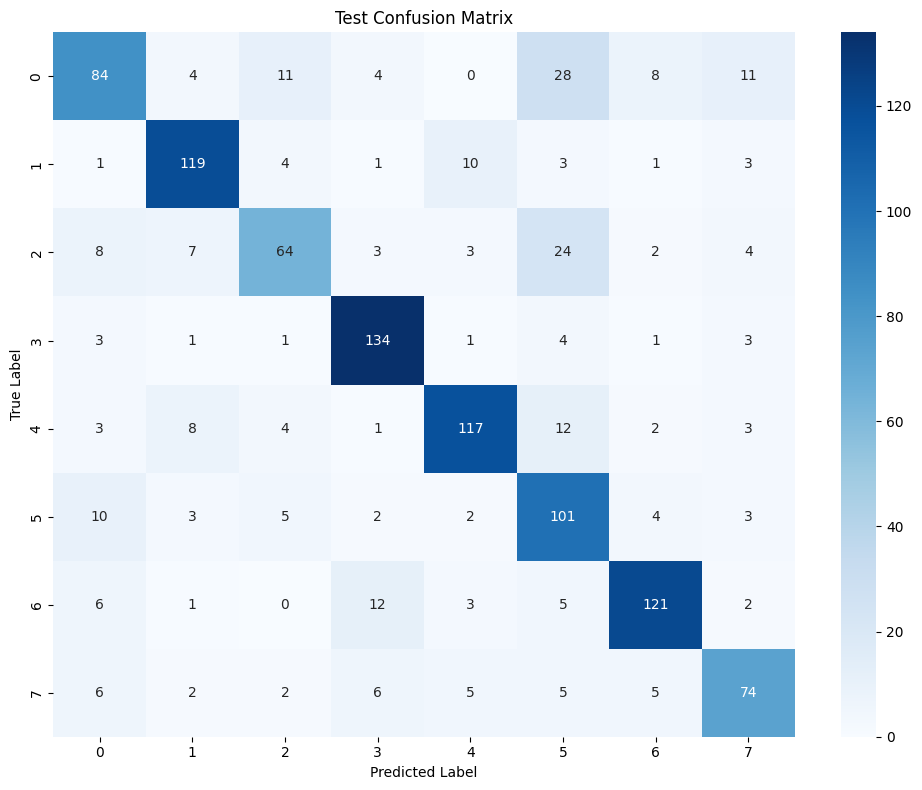

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7467889785766602     │
│        test_auroc         │    0.9557700157165527     │
│       test_f1_score       │    0.7398146390914917     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.7467889785766602,
  'test_f1_score': 0.7398146390914917,
  'test_auroc': 0.9557700157165527}]

In [ ]:
# Load the model checkpoint correctly using the class itself
checkpoint_path = Path('checkpoints/resnet18/resnet18-v3-epoch=17-val_acc=0.75.ckpt')

# Load the model from the checkpoint (using the class, not an instance)
lit_model = LitResNet3.load_from_checkpoint(checkpoint_path, num_classes=garbage_classification_data.n_classes)

# Testing setup (no training)
trainer = L.Trainer(accelerator='gpu')

# Run the test phase
trainer.test(model=lit_model, datamodule=garbage_classification_data)

In [ ]:
"""
- create more flexible model that switch between diff ResNet architectures (like ResNet-34, ResNet-50, or ResNet-101)
"""

class DiceLoss(nn.Module):
    def forward(self, inputs, targets, epsilon=1e-6):
        # Apply softmax to the inputs for multi-class classification
        inputs = torch.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).float()

        intersection = (inputs * targets).sum(dim=1)
        union = inputs.sum(dim=1) + targets.sum(dim=1)
        dice_score = (2. * intersection + epsilon) / (union + epsilon)
        return 1 - dice_score.mean()

def label_smoothed_nll_loss(lprobs, target, eps=0.1):
    nll_loss = -lprobs.gather(dim=-1, index=target.unsqueeze(-1))
    nll_loss = nll_loss.squeeze(-1)
    nll_loss = (nll_loss * (1.0 - eps)) + (lprobs.mean(dim=-1) * eps)
    return nll_loss.sum()

class ResNetModel2(nn.Module):
    def __init__(self, n_classes, resnet_version='resnet18'):
        super().__init__()
        # Dynamically load the ResNet model based on the version
        self.model = getattr(models, resnet_version)(weights=getattr(models, f'{resnet_version.replace("resnet", "ResNet")}_Weights').DEFAULT)

        # Modify the first convolution layer to accept grayscale input
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        with torch.no_grad():
            self.model.conv1.weight.data = original_conv.weight.data[:, :1, :, :]

        # Adjust the fully connected layer to match the number of classes
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.model(x)


class LitResNet4(L.LightningModule):
    def __init__(self, num_classes, resnet_version):
        super().__init__()
        self.num_classes = num_classes
        self.model = ResNetModel2(num_classes, resnet_version)
        # self.loss_fn = FocalLoss()
        self.loss_fn = DiceLoss()

        # Metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.test_precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=num_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        self.test_outputs = []


        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        # loss = self.loss_fn(outputs, labels)

        lprobs = F.log_softmax(outputs, dim=-1)
        loss = label_smoothed_nll_loss(lprobs, labels, eps=0.1)  # Adjust epsilon if needed

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        images, labels = batch
        print(f"[Test Step] Batch {batch_idx} - Images: {images.shape}, Labels: {labels.shape}")

        outputs = self(images)
        preds = outputs.argmax(dim=1)

        # Check for empty tensors before updating metrics
        if preds.numel() == 0 or labels.numel() == 0:
            print(f"[Test Step] Skipping empty batch {batch_idx}")
            return {'test_loss': torch.tensor(0.0)}

        # Update metrics
        self.test_accuracy.update(preds, labels)
        self.test_f1.update(preds, labels)
        self.test_auroc.update(torch.nn.functional.softmax(outputs, dim=1), labels)
        self.test_confusion_matrix.update(preds, labels)

        loss = self.loss_fn(outputs, labels)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)

        return {'test_loss': loss}

    def on_test_epoch_end(self):
        try:
            accuracy = self.test_accuracy.compute()
            f1_score = self.test_f1.compute()
            auroc = self.test_auroc.compute()
            conf_mat = self.test_confusion_matrix.compute().cpu().numpy()
        except ValueError as e:
            print(f"Error in metric computation: {e}")
            print(f"Test Accuracy State: {self.test_accuracy._computed}")
            print(f"Test F1 State: {self.test_f1._computed}")
            print(f"Test AUROC State: {self.test_auroc._computed}")
            print(f"Test Confusion Matrix State: {self.test_confusion_matrix._computed}")
            return

        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        self.log('test_accuracy', accuracy)
        self.log('test_f1_score', f1_score)
        self.log('test_auroc', auroc)

        # Reset metrics
        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()



    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optimizer, mode='max', factor=0.5, patience=3, verbose=True
        # )
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_acc'
            }
        }


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


Using device: cuda


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | ResNetModel2              | 59.2 M | train
1 | loss_fn               | DiceLoss                  | 0      | train
2 | test_accuracy         | MulticlassAccuracy        | 0      | train
3 | test_f1               | MulticlassF1Score         | 0      | train
4 | test_precision        | MulticlassPrecision       | 0      | train
5 | test_recall           | MulticlassRecall          | 0      | train
6 | test_auroc            | MulticlassAUROC           | 0      | train
7 | test_confusion_matrix | MulticlassConfusionMatrix | 0    


--- Starting training with resnet152 ---


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.505


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.033 >= min_delta = 0.0. New best score: 0.538


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.071 >= min_delta = 0.0. New best score: 0.610


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.050 >= min_delta = 0.0. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.038 >= min_delta = 0.0. New best score: 0.698


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.067 >= min_delta = 0.0. New best score: 0.764


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.769


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.786
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Starting testing ---


Testing: |          | 0/? [00:00<?, ?it/s]

Running test step: batch 0
Running test step: batch 1
Running test step: batch 2
Running test step: batch 3
Running test step: batch 4
Running test step: batch 5
Running test step: batch 6
Running test step: batch 7
Running test step: batch 8
Running test step: batch 9
Running test step: batch 10
Running test step: batch 11
Running test step: batch 12
Running test step: batch 13
Running test step: batch 14
Running test step: batch 15
Running test step: batch 16
Running test step: batch 17

--- Test Metrics ---
Accuracy: 0.7798
Macro F1 Score: 0.7718
Precision: 0.7763
Recall: 0.7718
AUROC: 0.9642


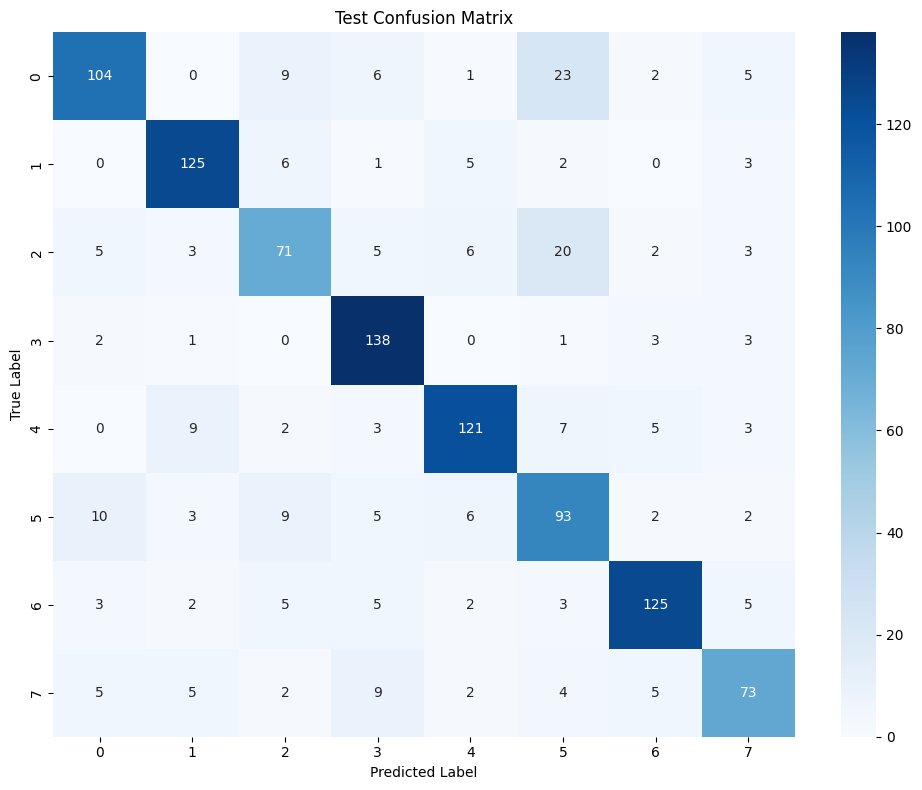

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7798165082931519     │
│        test_auroc         │    0.9642056822776794     │
│       test_f1_score       │     0.771848201751709     │
│      test_precision       │    0.7763054966926575     │
│        test_recall        │    0.7717577219009399     │
└───────────────────────────┴───────────────────────────┘


--- Confusion Matrix and Test Metrics ---


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was c

ValueError: No samples to concatenate

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training script setup
checkpoint_dir = Path('checkpoints/resnet18')
checkpoint_callback = L.callbacks.ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='resnet152-v4-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    monitor='val_acc',
    mode='max'
)

# Early stopping callback
early_stopping_callback = L.callbacks.EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=5,
    verbose=True
)

logger = L.loggers.TensorBoardLogger(save_dir='logs', name='resnet18')

trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',  # Ensure GPU is being used
    devices=1,          # Use a single GPU
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=logger,
    log_every_n_steps=10,  # Log more frequently
)

# Create the data module
garbage_classification_data = GarbageClassificationData(num_workers=4)
# garbage_classification_data.print_class_distribution()

# Initialize the model with the desired ResNet version (can be changed as needed)
resnet_version = 'resnet152'  # Options: resnet18, resnet34, resnet50, resnet101, resnet152
lit_model = LitResNet4(garbage_classification_data.n_classes, resnet_version)

# Train the model
print(f"\n--- Starting training with {resnet_version} ---")
trainer.fit(model=lit_model, datamodule=garbage_classification_data)

# Test the model after training
print("\n--- Starting testing ---")
trainer.test(model=lit_model, datamodule=garbage_classification_data)

print("\n--- Confusion Matrix and Test Metrics ---")
lit_model.on_test_epoch_end()
